In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00


In [2]:
!pip install seaborn matplotlib

In [3]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix

Dyanmically Importing Data From Drive

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

My Drive Link -- https://drive.google.com/drive/folders/1YNYYFPXxMwGHmPl03Ede033DT5Op76Nk?usp=sharing

Reading Train Data

In [5]:
train_data = pd.read_csv('/content/train.En.csv')
print(train_data.columns)

texts = train_data['tweet'].tolist()
labels = train_data['sarcastic'].tolist()

Index(['Unnamed: 0', 'tweet', 'sarcastic', 'rephrase', 'sarcasm', 'irony',
       'satire', 'understatement', 'overstatement', 'rhetorical_question'],
      dtype='object')


Reading Test Data

In [6]:
# test_data = pd.read_csv('/content/drive/MyDrive/CSE_440/Test Data/task_A_En_test.csv')
# test_data = pd.read_csv('/content/drive/MyDrive/CSE_440/Test Data/task_B_En_test.csv')
# test_data = pd.read_csv('/content/drive/MyDrive/CSE_440/Test Data/task_C_En_test.csv')

# If uploading to Colab Uncomment those as required
test_data = pd.read_csv('/content/task_A_En_test.csv')
# test_data = pd.read_csv('/content/task_B_En_test.csv')
# test_data = pd.read_csv('/content/task_C_En_test.csv')
print(test_data.columns)

# For Test Data "A"
test_texts = test_data['text'].tolist()
test_labels = test_data['sarcastic'].tolist()


# For Test Data "B"
# test_texts = test_data['text'].tolist()
# test_labels = test_data['sarcasm'].tolist()

# For Test Data "C"
# Combining two Texts
# test_data['combined_text'] = test_data['text_0'] + ' ' + test_data['text_1']
# test_texts = test_data['combined_text'].tolist()
# test_labels = test_data['sarcastic_id'].tolist()

Index(['text', 'sarcastic'], dtype='object')


In [7]:
print(test_texts)

["Size on the the Toulouse team, That pack is monstrous. \n\nI can't see a Welsh region ever winning this, Money talks as they say .", 'Pinball!', "So the Scottish Government want people to get their booster shots so badly that the website doesn't even work", 'villainous pro tip : change the device name on her bluetooth devices so she doesn’t forget u', 'I would date any of these men 🥺', "If there's one fictional place I could go, Christmas at Hogwarts would be that place", "I mean, it's a great cause they're doing it for, but can we not have new Xmas music that's... well... good?!", 'Where did they get 1.22xg from without the pen?!', 'There was so much interest in your Venice series Peg, the hand colouring is exquisite!👌🏽👏🏽👍🏽', 'Sometimes I lay in bed and think about how today will be the day I make my life better. Exercise, drinking water, eating healthy. Then I wake up. ', 'This does not surprise me! Kat is a PR queen 👑💕🌟👏🏻', 'Also a shame that most of our media are ignoring this bu

Preprocessing using BERT tokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Remove NaN Values: Before tokenizing, ensure that your texts list doesn't have any nan values. We filter out these values.d
texts = [text for text in texts if pd.notna(text)]

# # Replace NaN Values: Alternatively, you can replace nan values with a placeholder string (like "[UNK]" which stands for "unknown" in BERT's vocabulary)
# texts = [text if pd.notna(text) else "[UNK]" for text in texts]


input_ids = [tokenizer.encode(text, add_special_tokens=True) for text in texts]

Padding input_ids

In [9]:
max_len = max([len(ids) for ids in input_ids])
input_ids = [ids + [0] * (max_len - len(ids)) for ids in input_ids]
input_ids = torch.tensor(input_ids)

Attention masks

In [10]:
attention_masks = [[float(id != 0) for id in ids] for ids in input_ids]

Equalize the lengths of input_ids and labels (OpenAI)

In [11]:
min_length = min(len(input_ids), len(labels))
input_ids = input_ids[:min_length]
labels = labels[:min_length]


Split Data (OpenAi)

In [12]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(
    input_ids, labels, attention_masks, test_size=0.2, random_state=42)


Attention Mask (OpenAi)

In [13]:
attention_masks = [[1 if token_id > 0 else 0 for token_id in input_id] for input_id in input_ids]

Splitting into training and validation sets

In [14]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.2)

Convert to PyTorch data types

In [15]:
train_inputs, val_inputs = torch.tensor(train_inputs), torch.tensor(val_inputs)
train_labels, val_labels = torch.tensor(train_labels), torch.tensor(val_labels)
train_masks, val_masks = torch.tensor(train_masks), torch.tensor(val_masks)

<ipython-input-15-85cba0a2060d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs, val_inputs = torch.tensor(train_inputs), torch.tensor(val_inputs)


Create DataLoader

In [16]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_loader = DataLoader(val_data, batch_size=32)

Model

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training

In [18]:
model.train()
for epoch in range(3):  # Number of epochs
    for batch in train_loader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

Preprocessing test data

In [19]:
# Ensure no NaN values in test_texts before encoding
test_texts = [text for text in test_texts if pd.notna(text)]

# Encode, truncate to max_len if longer, or pad with 0's if shorter
test_input_ids = [tokenizer.encode(text, add_special_tokens=True) for text in test_texts]
test_input_ids = [ids[:max_len] + [0] * (max_len - len(ids)) for ids in test_input_ids]

# Convert to torch tensor
test_input_ids = torch.tensor(test_input_ids)

Attention masks for test data

In [20]:
test_attention_masks = [[float(id != 0) for id in ids] for ids in test_input_ids]

Convert to PyTorch data types

In [21]:
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)

<ipython-input-21-07d781131ab7>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_input_ids)


Create DataLoader for test data

In [22]:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_data, batch_size=32)

Evaluation on test data

In [23]:
model.eval()
true_labels = []
predicted_labels = []
correct = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, masks, labels = batch
        outputs = model(inputs, attention_mask=masks)
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()

        # Append true and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predictions.tolist())


print(f'Test Accuracy: {correct / len(test_labels)}')

Test Accuracy: 0.855


Calculate precision, recall, and confusion matrix

In [24]:
# true_labels = []
# predicted_labels = []

In [27]:
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Confusion Matrix:\n{conf_matrix}')

Precision: 0.0
Recall: 0.0
Confusion Matrix:
[[1197    3]
 [ 200    0]]


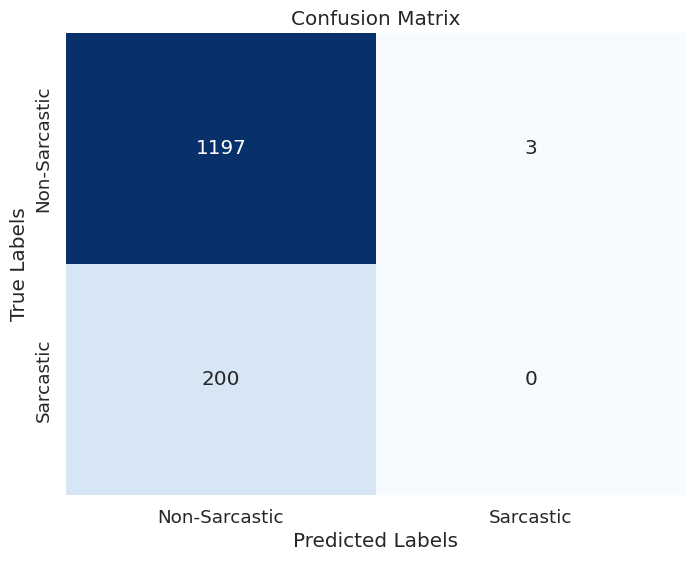

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()